<a href="https://colab.research.google.com/github/jihyeon602/DeepLearning_practice/blob/main/231121_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os, glob
import scipy
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
# 비전딥러닝 관련 : https://wikidocs.net/135874

In [3]:
!unzip -q /content/drive/MyDrive/Chest_Xray/ChestXRay2017.zip

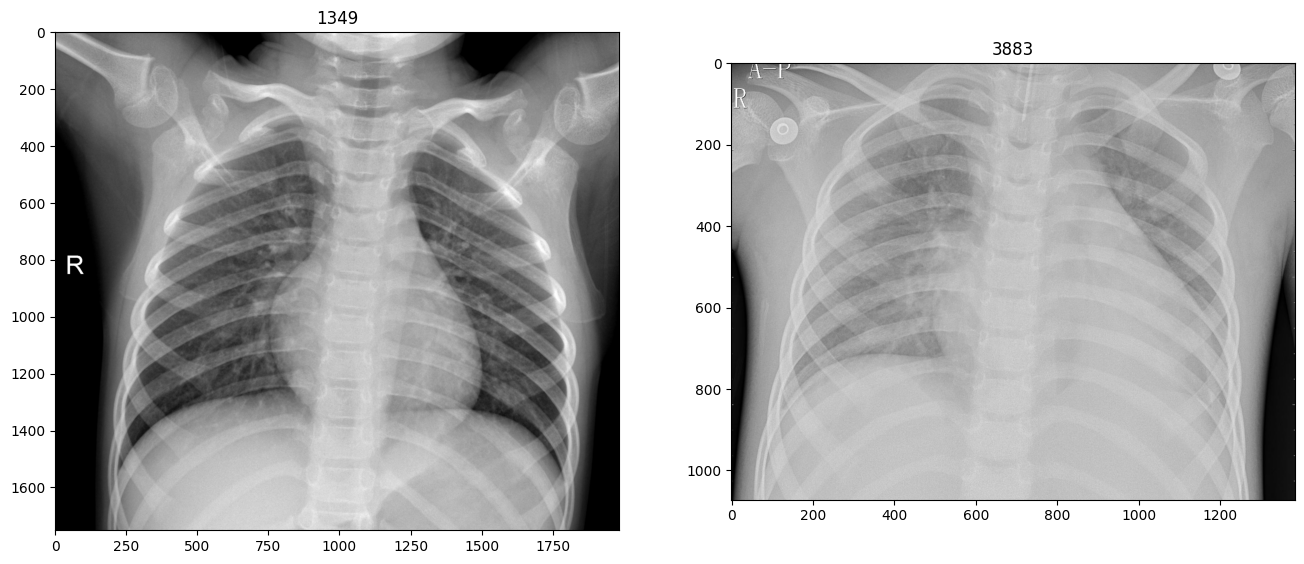

In [8]:
# Preview Dataset
BASE_PATH = '/content/drive/MyDrive/Chest_Xray/chest_xray/train/'

#경로리스트 수집
normal_list = glob.glob(os.path.join(BASE_PATH, 'NORMAL/*.jpeg'))
pneumonia_list = glob.glob(os.path.join(BASE_PATH, 'PNEUMONIA/*.jpeg'))

#로드(정상 vs 폐렴)
normal_img = img_to_array(load_img(normal_list[0]), dtype=np.uint8)
pneumonia_img = img_to_array(load_img(pneumonia_list[0]), dtype=np.uint8)

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title(len(normal_list))
plt.imshow(normal_img)
plt.subplot(1, 2, 2)
plt.title(len(pneumonia_list))
plt.imshow(pneumonia_img)

In [10]:
# DataGenerator
# 어그멘테이션
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.01,
    zoom_range=[0.9, 1.1],
    validation_split=0.1, # val 10%
    preprocessing_function=preprocess_input # keras
)

val_datagen = ImageDataGenerator(
    validation_split=0.1,
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['NORMAL', 'PNEUMONIA'], #[1, 0] [0, 1]
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    BASE_PATH,
    target_size=(224, 224),
    classes=['NORMAL', 'PNEUMONIA'],
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset='validation'
)

print(val_gen.class_indices)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [11]:
# Load Model for Transfer Learning
base_model = MobileNetV2(input_shape=(224, 224, 3), weights='imagenet', include_top=False) #1000이미지 분류 모델(동결)

x = base_model.output
x = GlobalAveragePooling2D()(x) # 1차원으로 피기
output = Dense(2, activation='softmax')(x) #[1,0][0,1], 2개

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,226,434 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [12]:
# Switch Layers to be Trainable # 레이어 웨이트 변경 방지
for layer in model.layers:
    layer.trainable = True

In [13]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[
        ModelCheckpoint('model.keras', monitor='val_acc', save_best_only=True, verbose=1) # model.h5 => model.keras
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.8988 - loss: 0.2382
Epoch 1: val_acc improved from -inf to 0.93870, saving model to model.keras
148/148 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - acc: 0.8991 - loss: 0.2376 - val_acc: 0.9387 - val_loss: 0.2817
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 924ms/step - acc: 0.9662 - loss: 0.0927
Epoch 2: val_acc did not improve from 0.93870
148/148 ━━━━━━━━━━━━━━━━━━━━ 181s 994ms/step - acc: 0.9662 - loss: 0.0927 - val_acc: 0.8046 - val_loss: 1.1066
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - acc: 0.9686 - loss: 0.0820
Epoch 3: val_acc did not improve from 0.93870
148/148 ━━━━━━━━━━━━━━━━━━━━ 139s 942ms/step - acc: 0.9687 - loss: 0.0820 - val_acc: 0.5785 - val_loss: 3.5443
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - acc: 0.9765 - loss: 0.0675
Epoch 4: val_acc did not improve from 0.93870
148/148 ━━━━━━━━━━━━━━━━━━━━ 134s 903ms/step - acc: 0.9765 - loss: 0.0675 - val_acc: 0.5402 - val_loss: 3.4789
Epoch 5/10
148/1

In [14]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [15]:
# Create New Model
model = load_model('model.keras')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2) 차원수

new_model = Model(
    inputs=model.input,
    outputs=(
        model.layers[-3].output, # the layer just before GAP, for using spatial features: 공간정보를 펴지않고 그대로 쓰겠다
        model.layers[-1].output
    )
)

new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,226,434 (8.49 MB)

 Non-trainable params: 34,112 (133.25 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


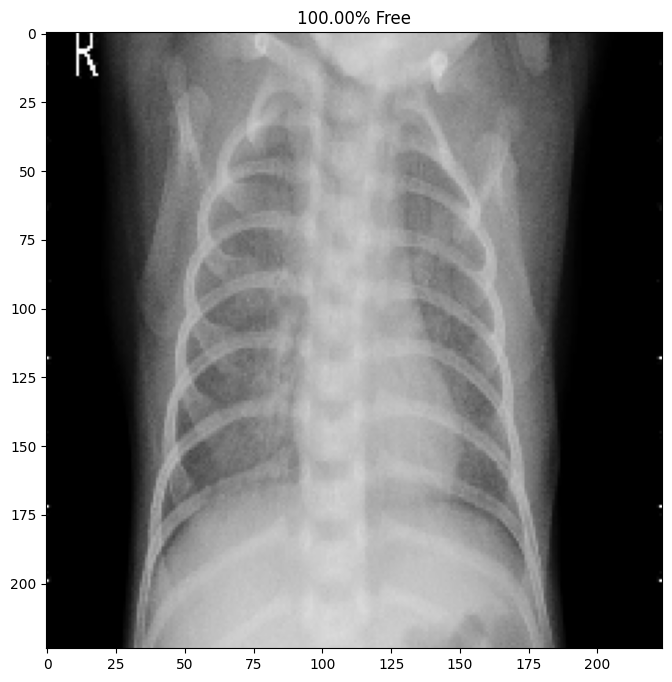

In [50]:
# Normal Prediction
'''
test_img_path = '/content/drive/MyDrive/Chest_Xray/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
'''
test_img_path = '/content/drive/MyDrive/Chest_Xray/chest_xray/test/PNEUMONIA/person1675_virus_2891.jpeg'
test_img = img_to_array(load_img(test_img_path, target_size=(224, 224)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = model.predict(test_input)

plt.figure(figsize=(8, 8))
plt.title('%.2f%% Free' % (pred[0][1] * 100))
plt.imshow(test_img.astype(np.uint8))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


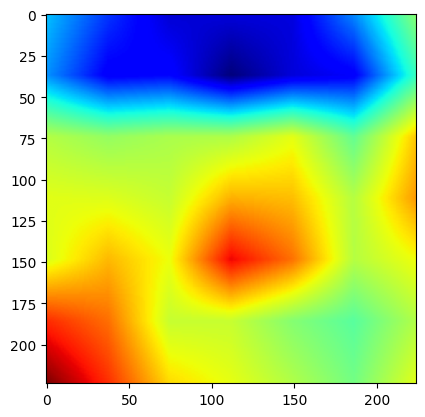

In [51]:
# Draw Activation Map
last_conv_output, pred = new_model.predict(test_input)

last_conv_output = np.squeeze(last_conv_output) # (7, 7, 1280) GAP 전
feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) # (7, 7, 1280) -> (224, 224, 1280)

pred_class = np.argmax(pred) # 0: normal, 1: pneumonia
predicted_class_weights = last_weight[:, pred_class] # (1280, 1) # GAP 생략

final_output = np.dot(feature_activation_maps.reshape((224*224, 1280)), predicted_class_weights).reshape((224, 224)) # (224*224, 1280) dot_product (1280, 1) = (224*224, 1)

plt.imshow(final_output, cmap='jet')

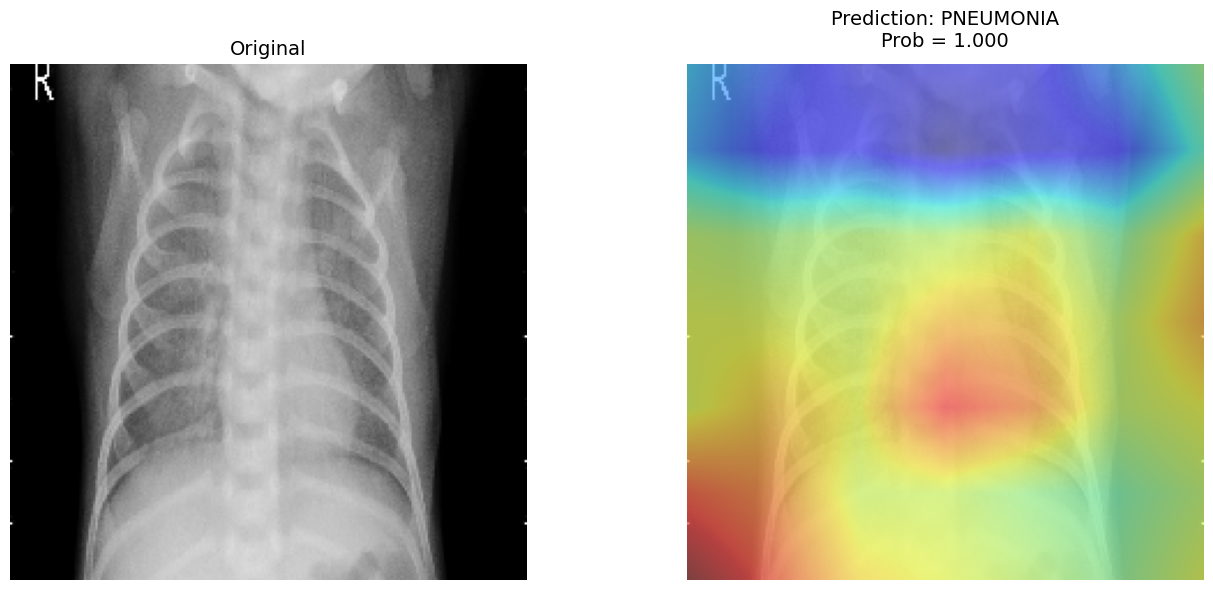

In [52]:
# result
class_names = ['NORMAL', 'PNEUMONIA']
confidence = pred[0][pred_class]  # softmax 확률

# CAM 시각화
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# 1. 원본 이미지
ax[0].imshow(test_img.astype(np.uint8), cmap='gray')
ax[0].set_title("Original", fontsize=14)
ax[0].axis('off')

# 2. CAM 결과 + 확률 + 클래스명
cam_img = ax[1].imshow(test_img.astype(np.uint8), alpha=0.5, cmap='gray')
cam_overlay = ax[1].imshow(final_output, cmap='jet', alpha=0.5)
ax[1].set_title(f"Prediction: {class_names[pred_class]}\nProb = {confidence:.3f}", fontsize=14, pad=12)
ax[1].axis('off')


plt.tight_layout()
plt.show()